<a href="https://colab.research.google.com/github/ethanarsht/detective-dogs/blob/Ethan/pneumonia_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# FIRST OBJECTIVE

# Choosing the relevant metrics is up to you. There are few things for things
# for you to consider.

# In choosing relevant metrics, I recommend considering at least one ACCURACY
# METRIC AND at leat one LOSS FUNCTION! 
# 1) measure of accuracy: 
#   sci-kit learn's page on this could be useful for you:
#   https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
#   there are many possible metrics to choose from: accuracy score, F1 score, 
#   precision-recall curve, etc
# 2) loss functions:
#   In class, we've seen Negative Log Loss, which works well for a binary
#   or a multi-class classification. There is also cross-entropy, which is
#   widely used for binary classifcation. There are other loss functions, too!
#   This blog post is a good starting point: https://neptune.ai/blog/pytorch-loss-functions

# CONSIDERATION: though this objective is listed first, I recommend coming to this
# after you built your model. As you build the train/val/test process, assessing
# accuracy and loss will be done pretty simply, often with a call of a single
# function/method for each metric. Start with the metrics you've seen in class
# and then consider branching out! 

In [ ]:
# SECOND OBJECTIVE

# Building a custom neural network! The exciting part <3

# FYI: HW4 will be a great introduction to using PyTorch to build a simple
# neural network.

In [ ]:

import os
import pandas as pd
import matplotlib.pyplot as plt

os.environ['TORCH_USE_CUDA_DSA']='1'

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image

from google.colab import drive
drive.mount("/content/drive")

import torch 
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

from sklearn.metrics import f1_score



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data ingestion and transformation


In [ ]:
def find_mean_std(loader):
    # Var[X] = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir_path, transform=None):
        """
        You can set your custom dataset to take in more parameters than specified
        here. But, I recommend at least you start with the three I listed here,
        as these are standard

        csv_file (str): file path to the csv file you created /
        df (pandas df): pandas dataframe

        img_dir_path: directory path to your images
        transform: Compose (a PyTorch Class) that strings together several
          transform functions (e.g. data augmentation steps)

        One thing to note -- you technically could implement `transform` within
        the dataset. No one is going to stop you, but you can think of the
        transformations/augmentations you do as a hyperparameter. If you treat
        it as a hyperparameter, you want to be able to experiment with different
        transformations, and therefore, it would make more sense to decide those
        transformations outside the dataset class and pass it to the dataset!
        """
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir_path
        self.transform = transform

    def __len__(self):
        """
        Returns: (int) length of your dataset
        """

        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """
        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label_str = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        
        label = 0 if label_str == "NORMAL" else 1

        return image, torch.tensor(label)



transforms = T.Compose(
    # Note: for development purposes, the image size has been set to 
    # 50 by 50 to speed up training. This should be increased as we progress in the development process
    [
        T.ToPILImage(),
        T.Resize((512,512)),  
        T.RandomRotation(40),
        T.RandomResizedCrop(50, scale=(0.8, 1.0), ratio=(0.8, 1.25)),
        T.RandomHorizontalFlip(),
        T.RandomAffine(degrees=0, shear=0.2, scale=(1, 1.2)),
        T.ColorJitter(
            brightness = 0.1
        ),
        T.ToTensor(),
        T.Normalize((0.5131,), (0.2161)),
        T.Grayscale(),
    ]
)

training_data = CustomImageDataset('drive/MyDrive/pneumonia_images/train/train.csv', 
                                   'drive/MyDrive/pneumonia_images/train/train_images', 
                                   transforms)
val_data = CustomImageDataset('drive/MyDrive/pneumonia_images/val/val.csv', 
                              'drive/MyDrive/pneumonia_images/val/val_images', 
                               transforms)
test_data = CustomImageDataset('drive/MyDrive/pneumonia_images/test/test.csv', 
                              'drive/MyDrive/pneumonia_images/test/test_images', 
                               transforms)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
# mean, std = find_mean_std(train_dataloader)
# print(mean)
# print(std)

We experimented with two transformation pipelines. Some of the operations in our initial pipeline included color jitter (with contrast and saturation adjustments), resizing, grayscale conversion, converting to float, and normalization. Converting the image to float and performing normalization turned out to be computationally expensive for our computers. Moreover, we contend that excessively modifying contrast and saturation can potentially obscure the visibility of pneumonia-related haziness, leading to inaccurate predictions. Some studies emphasize the need for careful consideration when employing color transformations, particularly in the context of medical images (Shorten 2019). 

The current transformation pipeline is less computationally complex because it involves fewer operations and less intensive transformations.The pipeline includes primarily geometric transformations such as resizing, rotation, cropping, flipping, affine transformation with some color transformation such as color jitter, grayscale conversion. We also added tensor conversion as it allows the model to process and operate on the image data efficiently, as neural networks typically work with tensors as input. These operations are relatively lightweight and can be computed quickly.
Both pipelines include common image augmentation techniques that can help improve the model's ability to generalize and detect features. However, the currrent pipeline includes a wider range of transformations, which may provide more diversity in the training data and potentially improve its performance.

Shorten, Connor and Taghi M. Khoshgoftaar. "On the Effectiveness of Data Augmentation for Deep Learning-Based Medical Image Analysis." Journal of Big Data, vol. 6, no. 1, 2019, pp. 1-15. doi: 10.1186/s40537-019-0197-0.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
status = 'GPU activated' if torch.cuda.is_available() else 'No GPU available'
print(status)

GPU activated


In [ ]:
## This cell is practice for building and implementing a neural network. 
## Use the one below.
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 8, 2, 1)
#         self.conv2 = nn.Conv2d(8, 16, 3, 1)
#         self.fc1 = nn.Linear(144, 64)
#         self.fc2 = nn.Linear(64, 2)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)

#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)

#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)

#         output = F.log_softmax(x, dim=1)
#         return output


# my_nn = Net().to(device)


# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(my_nn.parameters(), lr=0.001, momentum=0.9)

# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_dataloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         inputs = inputs.to(device)
#         label_tup = [0 if i == "NORMAL" else 1 for i in labels]
#         labels = torch.tensor(label_tup)
#         labels = labels.to(device)
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = my_nn(inputs)

#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

# print('Finished Training')

This is a simplified implementation of LeNet (thanks Ian!). We are planning to experiment with other network architectures, but this allows us to set up a functional pipeline to test loss functions and other parameters.

# Set up test-validate-train pipeline



In [ ]:
def train_validate_pipeline(criterion, model, optimizer, epochs, convnet = False):
  EPOCHS = epochs

  train_losses = []
  train_f1s = []
  val_losses = []
  val_f1s = []

  for epoch in range(EPOCHS):  # loop over the dataset multiple times

      # TRAIN
      model.train()
      running_loss = 0.0
      train_preds = []
      train_targets = []
      for i, (inputs, labels) in enumerate(train_dataloader, 1):
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)
          if convnet:
            loss = criterion(outputs.view(-1), labels.float())
            predicted = (torch.sigmoid(outputs.data) > 0.5).float()
          else:
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)

          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          train_preds.extend(predicted.cpu().numpy())
          train_targets.extend(labels.cpu().numpy().astype(int))

      avg_train_loss = running_loss / i
      avg_train_f1 = f1_score(train_targets, train_preds, average='binary')
      train_losses.append(avg_train_loss)
      train_f1s.append(avg_train_f1)

      # VALIDATE
      model.eval()
      val_running_loss = 0.0
      val_preds = []
      val_targets = []
      with torch.no_grad():
          for i, (inputs, labels) in enumerate(val_dataloader, 1):
              inputs = inputs.to(device)
              labels = labels.to(device)

              outputs = model(inputs)
              if convnet:
                loss = criterion(outputs.view(-1), labels.float())
                predicted = (torch.sigmoid(outputs.data) > 0.5).float()
              else:
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)

              val_running_loss += loss.item()

              val_preds.extend(predicted.cpu().numpy())
              val_targets.extend(labels.cpu().numpy().astype(int))


      avg_val_loss = val_running_loss / i
      avg_val_f1 = f1_score(val_targets, val_preds, average='binary')
      val_losses.append(avg_val_loss)
      val_f1s.append(avg_val_f1)

      print(f'Epoch {epoch+1}/{EPOCHS}: train_loss={avg_train_loss:.4f}, train_f1={avg_train_f1:.4f}, val_loss={avg_val_loss:.4f}, val_f1={avg_val_f1:.4f}')

  return train_losses, train_f1s, val_losses, val_f1s


In [ ]:
# 5: Test!
def test(criterion, model, convnet=False):
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    test_preds = []
    test_targets = []
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            if convnet:
              loss = criterion(outputs.view(-1), labels.float())
              predicted = (torch.sigmoid(outputs.data) > 0.5).float().view(-1)
              test_correct += (predicted == labels.float()).sum().item() 

            else:
              loss = criterion(outputs, labels)
              _, predicted = torch.max(outputs.data, 1)
              test_correct += (predicted == labels).sum().item() 
            test_running_loss += loss.item()
            test_total += labels.size(0)

            test_preds.extend(predicted.cpu().numpy().astype(int))
            test_targets.extend(labels.cpu().numpy().astype(int))

    test_loss = test_running_loss / (i + 1)
    test_f1 = f1_score(test_targets, test_preds, average='binary')
    test_accuracy = test_correct / test_total  
    return test_loss, test_f1, test_accuracy




# LeNet with Cross Entropy Loss Function

Our team conducted a literature review to determine which loss functions to include in our model. We reviewed an overview of PyTorch loss functions (see link below) and learned that there are three types of loss functions: (1) classification, (2) regression, and (3) ranking. Among the classification loss functions which are most pertinent to the binary classification task at hand, there are just two classification loss functions in the above article that are specific to binary (as opposed to multi) classification tasks: Cross-Entropy Loss and Hinge Embedding Loss. These are the two loss functions we initially selected for our model, but found coding Hinge Embedding Loss to be an added challenge. Consequently, we’ve added potentially trying out Hinge Embedding Loss to our list of potential future directions and decided to use Negative Log Loss, which we’ve gone over in class, for this version of the model. We will also continue to research and experiment with which loss functions will be most useful for this model.

https://neptune.ai/blog/pytorch-loss-functions

In [ ]:
class LeNet(nn.Module):
    def __init__(self, use_softmax = False):
        super().__init__()
        layers = [
            nn.Sequential(                                             
              nn.Conv2d(1, 6, kernel_size=9, stride=2, padding=1),    
              nn.BatchNorm2d(6),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2)),                  
            nn.Sequential(                                             
              nn.Conv2d(6, 16, kernel_size=9, stride=2, padding=1),    
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2)),                  
            # fully connected layers
            nn.Flatten(),
            nn.Linear(16 * 1 * 1, 2)   
        ]
        if use_softmax == True:
            layers.append(
                nn.Softmax(dim=1)
            )
        self.LeNet = nn.Sequential(
            *layers                                                       
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out

In [ ]:
criterion = nn.CrossEntropyLoss()
model = LeNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_validate_pipeline(
    criterion, model, optimizer, 50
)

Epoch 1/50: train_loss=0.4835, train_f1=0.8428, val_loss=0.6464, val_f1=0.7273
Epoch 2/50: train_loss=0.2998, train_f1=0.9195, val_loss=1.0213, val_f1=0.7273
Epoch 3/50: train_loss=0.2671, train_f1=0.9263, val_loss=0.6114, val_f1=0.7059
Epoch 4/50: train_loss=0.2499, train_f1=0.9285, val_loss=0.5516, val_f1=0.6667
Epoch 5/50: train_loss=0.2490, train_f1=0.9327, val_loss=1.3132, val_f1=0.7273
Epoch 6/50: train_loss=0.2277, train_f1=0.9371, val_loss=0.9970, val_f1=0.6957


KeyboardInterrupt: ignored

In [ ]:
test_loss, test_f1, test_accuracy = test(criterion, model)
print('Test loss: ', test_loss)
print("Test F1 score: ", test_f1)
print('Test accuracy score: ', test_accuracy)

Test loss:  0.3994983837008476
Test F1 score:  0.8802816901408451


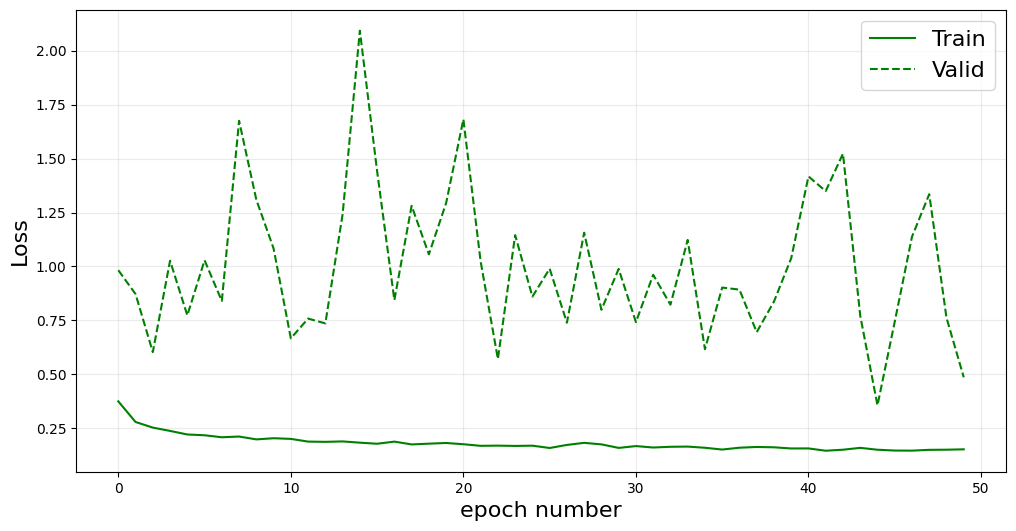

In [ ]:
epochs = [epoch for epoch in range(len(train_losses))]

## Plotting losses
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(epochs, train_losses, label='Train', color='green')
ax.plot(epochs, val_losses, label='Valid', linestyle='--', color='green')
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
ax.grid(alpha=0.25)
# ax.set_ylim((1, 3))
# ax.set_xlim((-1, 100))
ax.legend(loc="upper right", fontsize=16)

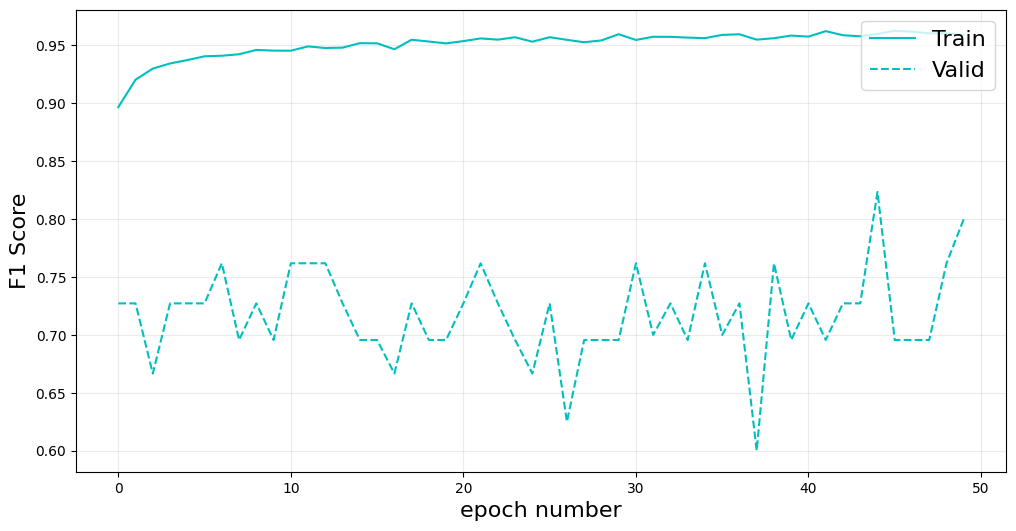

In [ ]:
## Plotting accuracies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(epochs, train_accuracies, label='Train', color='c')
ax.plot(epochs, val_accuracies, label='Valid', linestyle='--', color='c')
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("F1 Score", fontsize=16)
ax.grid(alpha=0.25)
# ax.set_ylim((1, 3))
# ax.set_xlim((-1, 100))
ax.legend(loc="upper right", fontsize=16)

Using **LeNet with Cross Entropy Loss function**, it can be observed how the accuracy in the training dataset slowly but gradually increases to the point where it almost reaches 1. This means that the model is predicting the correct class label for all pneumonia images in the test set. However, although the model has learned to identify patterns and features that distinguish different images, this accuracy improvement with each epoch does not imply that it will perform as good with unseen data. Therefore, it is possible to see that the performance of the model in the validating data has abrupt jumps and declines as the number of epochs increase. This means that the model is not accurate because it is not performing well with unseen data, and there is potentially evidence of overfitting on the training set.

# LeNet with Negative Log Loss Likelihood

In [ ]:
criterion = nn.NLLLoss()
model = LeNet(use_softmax = True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_validate_pipeline(
    criterion, model, optimizer, 20
)

In [ ]:
test_loss, test_accuracy = test(criterion, model)
print('Test loss: ', test_loss)
print("Test accuracy: ", test_accuracy)

In [ ]:
epochs = [epoch for epoch in range(len(train_losses))]

## Plotting losses
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(epochs, train_losses, label='Train', color='green')
ax.plot(epochs, val_losses, label='Valid', linestyle='--', color='green')
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
ax.grid(alpha=0.25)
# ax.set_ylim((1, 3))
# ax.set_xlim((-1, 100))
ax.legend(loc="upper right", fontsize=16)

In [ ]:
## Plotting accuracies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(epochs, train_accuracies, label='Train', color='c')
ax.plot(epochs, val_accuracies, label='Valid', linestyle='--', color='c')
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
ax.grid(alpha=0.25)
# ax.set_ylim((1, 3))
# ax.set_xlim((-1, 100))
ax.legend(loc="upper right", fontsize=16)

Using **LeNet with Negative Log Loss function**, it can be observed how the accuracy in the training dataset remains still for the first 8 epochs but then steeply increases its accuracy to the point where it almost reaches 1. This means that the model did not learn during the first epochs and could not predict the correct class label for the pneumonia images in the test. After the 8th epoch, the model has learned to identify patterns and features that distinguish different images and improves its accuracy. On the other hand, the model in the validating data did not perform well as the number of epochs increased since there are abrupt jumps and declines.





# ConvNet with Binary Cross Entropy with Logits Loss Function

In [ ]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*3*3, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out



In [ ]:
criterion = nn.BCEWithLogitsLoss()
model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_validate_pipeline(
    criterion, model, optimizer, 50, convnet = True
)

Epoch 1/50: train_loss=0.6354, train_f1=0.7969, val_loss=0.8490, val_f1=0.6667
Epoch 2/50: train_loss=0.5869, train_f1=0.8525, val_loss=0.8351, val_f1=0.6667
Epoch 3/50: train_loss=0.5813, train_f1=0.8525, val_loss=0.8539, val_f1=0.6667
Epoch 4/50: train_loss=0.5774, train_f1=0.8525, val_loss=0.8424, val_f1=0.6667
Epoch 5/50: train_loss=0.5746, train_f1=0.8525, val_loss=0.8183, val_f1=0.6667
Epoch 6/50: train_loss=0.5678, train_f1=0.8525, val_loss=0.8444, val_f1=0.6667
Epoch 7/50: train_loss=0.5615, train_f1=0.8525, val_loss=0.8531, val_f1=0.6667
Epoch 8/50: train_loss=0.5487, train_f1=0.8525, val_loss=0.8659, val_f1=0.6667
Epoch 9/50: train_loss=0.5296, train_f1=0.8525, val_loss=0.8778, val_f1=0.6667
Epoch 10/50: train_loss=0.4962, train_f1=0.8560, val_loss=0.8374, val_f1=0.6667
Epoch 11/50: train_loss=0.4417, train_f1=0.8739, val_loss=0.9016, val_f1=0.6667
Epoch 12/50: train_loss=0.3764, train_f1=0.8961, val_loss=1.0679, val_f1=0.7273
Epoch 13/50: train_loss=0.3325, train_f1=0.9075, 

In [ ]:
test_loss, test_f1, test_accuracy = test(criterion, model, convnet = True)
print('Test loss: ', test_loss)
print("Test F1 score: ", test_f1)
print("Test accuracy score: ", test_accuracy)

Test total: 64
Test total: 128
Test total: 192
Test total: 256
Test total: 320
Test total: 384
Test total: 448
Test total: 512
Test total: 576
Test total: 624
Test loss:  0.47932596653699877
Test F1 score:  0.8760139049826188
Test accuracy score:  0.8285256410256411


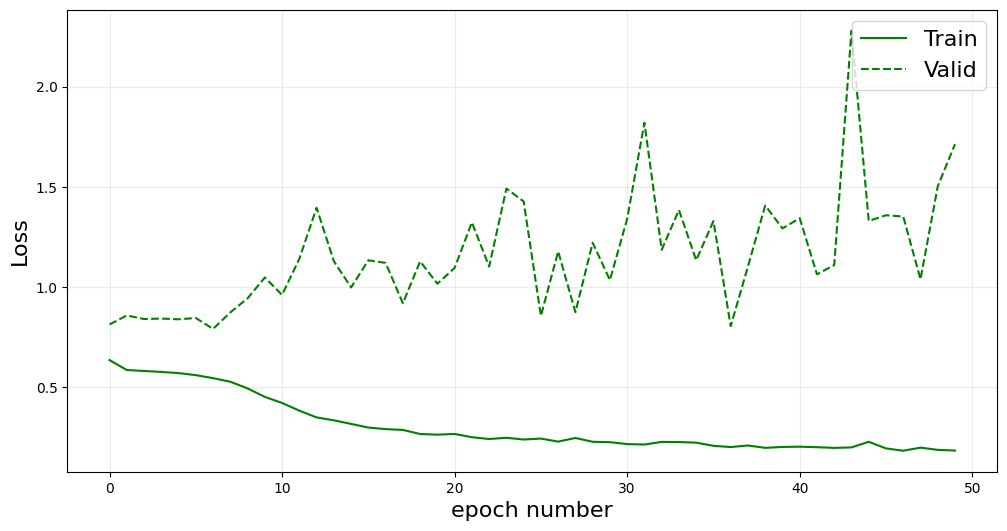

In [ ]:
epochs = [epoch for epoch in range(len(train_losses))]

## Plotting losses
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(epochs, train_losses, label='Train', color='green')
ax.plot(epochs, val_losses, label='Valid', linestyle='--', color='green')
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
ax.grid(alpha=0.25)
# ax.set_ylim((1, 3))
# ax.set_xlim((-1, 100))
ax.legend(loc="upper right", fontsize=16)

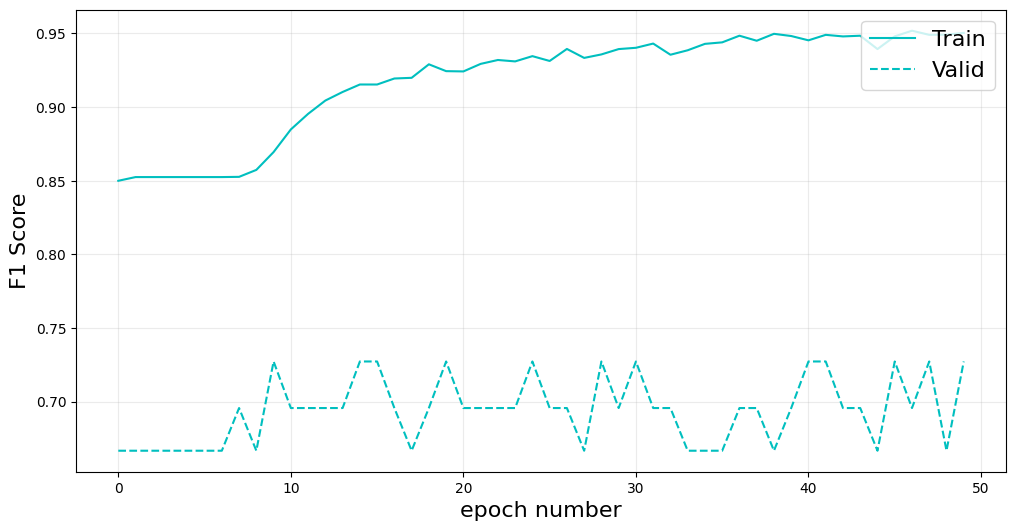

In [ ]:
## Plotting accuracies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(epochs, train_accuracies, label='Train', color='c')
ax.plot(epochs, val_accuracies, label='Valid', linestyle='--', color='c')
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("F1 Score", fontsize=16)
ax.grid(alpha=0.25)
# ax.set_ylim((1, 3))
# ax.set_xlim((-1, 100))
ax.legend(loc="upper right", fontsize=16)

In [ ]:
torch.save(model, "drive/MyDrive/pneumonia_images/convmodel.pt")